In [5]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import order_independent_llm
import order_independent_llm.plot_helpers
import json
import seaborn as sns
from functools import lru_cache
import multiprocessing

# Base paths
BASE_DIR = "/n/netscratch/dwork_lab/Lab/katrina/finetuning_sbp"
RESULTS_DIR_MMLU = "results/mmlu_quoted"
RESULTS_DIR_CSQA = "results/csqa_quoted"
OUTPUT_DIR = "/n/netscratch/dwork_lab/Lab/katrina/finetuning_sbp/meta-llama/Llama-2-7b-hf/20250105-005619_tags-False"


In [6]:
# Define model pairs (pre and post finetuning)
model_pairs = [
    {
        "name": "Llama-2-7b",
        "pre_path": "meta-llama_Llama-2-7b-hf-50",
        "output_dir": "/n/netscratch/dwork_lab/Lab/katrina/finetuning_sbp/meta-llama/Llama-2-7b-hf/20250105-005619_tags-False", # stores benchmarks.jsonl
    },
    {
        "name": "Llama-2-7b : QA",
        "pre_path": "meta-llama_Llama-2-7b-hf-50",
        "output_dir": "/n/netscratch/dwork_lab/Lab/katrina/finetuning_sbp/meta-llama/Llama-2-7b-hf/mmlu_quoted_qa/20250106-022456-False", # stores benchmarks.jsonl
    },
]

In [147]:
# Define model pairs (pre and post finetuning)
# NOTE: all trained with 2 epochs (I want to switch back to 3)
model_pairs = [
    {
        "name": "Llama-2-7b : QA",
        "pre_path": "meta-llama_Llama-2-7b-hf-50",
        "output_dir": "/n/netscratch/dwork_lab/Lab/katrina/finetuning_sbp/meta-llama/Llama-2-7b-hf/mmlu_quoted_qa/20250109-090124-False", # stores benchmarks.jsonl
    },
    {
        "name": "Llama-2-7b : QA+wiki",
        "pre_path": "meta-llama_Llama-2-7b-hf-50",
        "output_dir": "/n/netscratch/dwork_lab/Lab/katrina/finetuning_sbp/meta-llama/Llama-2-7b-hf/mmlu_quoted_qa_wiki/20250109-092335-False", # stores benchmarks.jsonl
    },
    {
        "name": "Llama-2-7b : Q only",
        "pre_path": "meta-llama_Llama-2-7b-hf-50",
        "output_dir": "/n/netscratch/dwork_lab/Lab/katrina/finetuning_sbp/meta-llama/Llama-2-7b-hf/20250105-005619_tags-False", # stores benchmarks.jsonl
    },
    #{
    #    "name": "Llama-2-7b : QA (Prev)",
    #    "pre_path": "meta-llama_Llama-2-7b-hf-50",
    #    "output_dir": "/n/netscratch/dwork_lab/Lab/katrina/finetuning_sbp/meta-llama/Llama-2-7b-hf/mmlu_quoted_qa/20250106-022456-False", # stores benchmarks.jsonl
    #},
    {
        "name": "Llama-2-7b : QA+s2d",
        "pre_path": "meta-llama_Llama-2-7b-hf-50",
        "output_dir": "/n/netscratch/dwork_lab/Lab/katrina/finetuning_sbp/meta-llama/Llama-2-7b-hf/mmlu_quoted_qa_s2d/20250109-094716-False", # stores benchmarks.jsonl
    },
]

In [142]:
# 4 models for comparison
model_pairs = [
    {
        "name": "Llama-2-7b : QA+wiki",
        "pre_path": "meta-llama_Llama-2-7b-hf-50",
        "output_dir": "/n/netscratch/dwork_lab/Lab/katrina/finetuning_sbp/meta-llama/Llama-2-7b-hf/mmlu_quoted_qa_wiki/20250109-092335-False", # stores benchmarks.jsonl
    },
    {
        "name": "Llama-2-7b-chat : QA+wiki",
        "pre_path": "meta-llama_Llama-2-7b-chat-hf-50",
        "output_dir": "/n/netscratch/dwork_lab/Lab/katrina/finetuning_sbp/meta-llama/Llama-2-7b-chat-hf/mmlu_quoted_qa_wiki/20250110-001813-False", # stores benchmarks.jsonl
    },
    {
        "name": "Llama-2-13b : QA+wiki",
        "pre_path": "meta-llama_Llama-2-13b-hf-50",
        "output_dir": "/n/netscratch/dwork_lab/Lab/katrina/finetuning_sbp/meta-llama/Llama-2-13b-hf/mmlu_quoted_qa_wiki/20250110-002528-False", # stores benchmarks.jsonl
    },
    {
        "name": "Llama-2-13b-chat : QA+wiki",
        "pre_path": "meta-llama_Llama-2-13b-chat-hf-50",
        "output_dir": "/n/netscratch/dwork_lab/Lab/katrina/finetuning_sbp/meta-llama/Llama-2-13b-chat-hf/mmlu_quoted_qa_wiki/20250109-235941-False", # stores benchmarks.jsonl
    },
]

    

In [135]:
# Llama-2-7b, trained on either MMLU or CSQA
model_pairs = [
    {
        "name": "Llama-2-7b : QA+wiki",
        "pre_path": "meta-llama_Llama-2-7b-hf-50",
        "output_dir": "/n/netscratch/dwork_lab/Lab/katrina/finetuning_sbp/meta-llama/Llama-2-7b-hf/mmlu_quoted_qa_wiki/20250109-092335-False", # stores benchmarks.jsonl
    },
    {
        "name": "Llama-2-7b : QA+wiki : train_csqa",
        "pre_path": "meta-llama_Llama-2-7b-hf-50",
        "output_dir": "/n/netscratch/dwork_lab/Lab/katrina/finetuning_sbp/meta-llama/Llama-2-7b-hf/csqa_quoted_qa_wiki/20250112-040235-False", # stores benchmarks.jsonl
    },
]

In [148]:
for i in range(len(model_pairs)):
    print(model_pairs[i]["output_dir"])
    if "s2d" not in model_pairs[i]["output_dir"]:
        model_pairs[i]["post_path_csqa"] = f"results/csqa_quoted/"+model_pairs[i]["output_dir"].replace("/","_")+"_final_weights-50"
        model_pairs[i]["post_path_mmlu"] = f"results/mmlu_quoted/"+model_pairs[i]["output_dir"].replace("/","_")+"_final_weights-50"
    else:
        model_pairs[i]["post_path_csqa"] = f"results/csqa_quoted_s2d/"+model_pairs[i]["output_dir"].replace("/","_")+"_final_weights-50"
        model_pairs[i]["post_path_mmlu"] = f"results/mmlu_quoted_s2d/"+model_pairs[i]["output_dir"].replace("/","_")+"_final_weights-50"
    model_pairs[i]["pre_path_csqa"] = f"results/csqa_quoted/"+model_pairs[i]["pre_path"]
    model_pairs[i]["pre_path_mmlu"] = f"results/mmlu_quoted/"+model_pairs[i]["pre_path"]
    model_pairs[i]["pre_path_csqa_perm"] = f"results/csqa_quoted_permutations/"+model_pairs[i]["pre_path"]
    model_pairs[i]["pre_path_mmlu_perm"] = f"results/mmlu_quoted_permutations/"+model_pairs[i]["pre_path"]


/n/netscratch/dwork_lab/Lab/katrina/finetuning_sbp/meta-llama/Llama-2-7b-hf/mmlu_quoted_qa/20250109-090124-False
/n/netscratch/dwork_lab/Lab/katrina/finetuning_sbp/meta-llama/Llama-2-7b-hf/mmlu_quoted_qa_wiki/20250109-092335-False
/n/netscratch/dwork_lab/Lab/katrina/finetuning_sbp/meta-llama/Llama-2-7b-hf/20250105-005619_tags-False
/n/netscratch/dwork_lab/Lab/katrina/finetuning_sbp/meta-llama/Llama-2-7b-hf/mmlu_quoted_qa_s2d/20250109-094716-False


In [137]:
# Add Llama-2-7b after 1 epoch of training (as comparison to see if catastrophic forgetting is reduced)
model_pairs.append({k:v for k,v in model_pairs[0].items()})
model_pairs[-1]["name"] = "Llama-2-7b : QA+wiki (1 epoch)"
model_pairs[-1]["post_path_csqa"] = model_pairs[-1]["post_path_csqa"].replace("final_weights","checkpoint-493")
model_pairs[-1]["post_path_mmlu"] = model_pairs[-1]["post_path_mmlu"].replace("final_weights","checkpoint-493")

In [138]:
model_pairs

[{'name': 'Llama-2-7b : QA+wiki',
  'pre_path': 'meta-llama_Llama-2-7b-hf-50',
  'output_dir': '/n/netscratch/dwork_lab/Lab/katrina/finetuning_sbp/meta-llama/Llama-2-7b-hf/mmlu_quoted_qa_wiki/20250109-092335-False',
  'post_path_csqa': 'results/csqa_quoted/_n_netscratch_dwork_lab_Lab_katrina_finetuning_sbp_meta-llama_Llama-2-7b-hf_mmlu_quoted_qa_wiki_20250109-092335-False_final_weights-50',
  'post_path_mmlu': 'results/mmlu_quoted/_n_netscratch_dwork_lab_Lab_katrina_finetuning_sbp_meta-llama_Llama-2-7b-hf_mmlu_quoted_qa_wiki_20250109-092335-False_final_weights-50',
  'pre_path_csqa': 'results/csqa_quoted/meta-llama_Llama-2-7b-hf-50',
  'pre_path_mmlu': 'results/mmlu_quoted/meta-llama_Llama-2-7b-hf-50',
  'pre_path_csqa_perm': 'results/csqa_quoted_permutations/meta-llama_Llama-2-7b-hf-50',
  'pre_path_mmlu_perm': 'results/mmlu_quoted_permutations/meta-llama_Llama-2-7b-hf-50'},
 {'name': 'Llama-2-7b : QA+wiki : train_csqa',
  'pre_path': 'meta-llama_Llama-2-7b-hf-50',
  'output_dir': '/n

In [12]:
# /n/netscratch/dwork_lab/Lab/katrina/set-based-prompting-finetuning/results/csqa_quoted/_n_netscratch_dwork_lab_Lab_katrina_finetuning_sbp_meta-llama_Llama-2-7b-hf_mmlu_quoted_qa_wiki_20250109-092335-False_checkpoint-493-50

In [ ]:
from concurrent.futures import ThreadPoolExecutor

@lru_cache
def load_results(model_path):
    """Load results for a given model and dataset type (MMLU or CSQA)"""
    files = glob.glob(f"*{model_path}/*.jsonl")
    
    if not files:
        model_path = model_path.replace("final_weights-50","final_weights_-50")
        files = glob.glob(f"*{model_path}/*.jsonl")
    if not files:
        model_path = "/n/netscratch/dwork_lab/Lab/katrina/set-based-prompting-finetuning/"+model_path
        files = glob.glob(f"{model_path}/*.jsonl")
    if not files:
        model_path = model_path.replace("final_weights_-50","final_weights-50")
        files = glob.glob(f"{model_path}/*.jsonl")
    if not files:
        print(f"No results found for {model_path}")
        return None
    
    #df = pd.concat([order_independent_llm.load_to_dataframe(f, fail_on_empty=False) for f in files])
    def load(x):
        return order_independent_llm.load_to_dataframe(x,fail_on_empty=False, include_probs=False)
    with ThreadPoolExecutor() as executor:
        dataframes = list(executor.map(load, files))
    
    # Combine all dataframes into one
    df = pd.concat(dataframes)
    print(f"Loading {df.shape} results from {model_path}")
    return df

In [130]:


def create_permutation_boxplot(model_results, dataset_type, output_name, suffix=""):
    """Create boxplot showing distribution of accuracies across permutations for all models"""
    df = pd.concat([model_info['pre_data_perm'].assign(model=model_info['name']) for model_info in model_results])#.drop_duplicates()
    df_post = pd.concat([model_info['post_data'].assign(model=model_info['name']) for model_info in model_results])#.drop_duplicates()
    '''
    'response_type', 'model', 'max_new_tokens', 'order_independent_output',
       'pad_attention', 'text_output', 'is_correct_answer',
       'correct_answer_prob', 'raw_output_contains_correct_answer_only',
       'edit_position', 'edit_attention', 'label_scores', 'label_perplexities',
       'probs', 'meta_label', 'meta_incorrect_answers', 'prompt', 'file_name'
    '''
    #df_post['model'] = "meta-llama/" + df_post['model']
    #df['model'] = "meta-llama/" + df['model']

    # only include rows with matching file_name and prompt
    common_keys = set(df['prompt']) & set(df_post['prompt'])
    df = df[df['prompt'].isin(common_keys)]
    df_post = df_post[df_post['prompt'].isin(common_keys) & (df_post['response_type'] == 'order_independent')]
    print(f"After filtering to only create permutation boxplot from common rows: df_post.shape={df_post.shape}")
    print(df_post["model"].value_counts())
    #print(df['model'].value_counts())
    perms = list(df['response_type'].unique())[3:]
    
    # 1. Gather all y-values in one array/Series:
    df_means       = df[df['response_type'].isin(perms)]\
                        [['model','is_correct_answer','response_type']]\
                        .groupby(['model','response_type'])\
                        .mean()['is_correct_answer']
    df_post_means  = df_post[df_post['response_type'] == 'order_independent']\
                        [['model','is_correct_answer','response_type']]\
                        .groupby(['model','response_type'])\
                        .mean()['is_correct_answer']
    df_pre_means   = df[df['response_type'] == 'order_independent']\
                        [['model','is_correct_answer','response_type']]\
                        .groupby(['model','response_type'])\
                        .mean()['is_correct_answer']
    
    all_y_values = pd.concat([df_means, df_post_means, df_pre_means])
    
    # 2. Compute the global min and max of all_y_values:
    y_min, y_max = all_y_values.min(), all_y_values.max()
    
    # 3. Plot:
    fig, ax = plt.subplots(figsize = (7,5))
    
    sns.boxplot(
        x='model',
        y='is_correct_answer',
        data=df_means.reset_index(),
        ax=ax,
        whis=[0, 100],
        width=.6,
    )
    sns.stripplot(
        x='model',
        y='is_correct_answer',
        data=df_means.reset_index(),
        ax=ax,
        label='Normal Model',
    )
    sns.scatterplot(
        x='model',
        y='is_correct_answer',
        data=df_post_means.reset_index(),
        ax=ax,
        s=100,
        label='Post-Finetuning Order Independent Model',
        zorder=5,
    )
    sns.scatterplot(
        x='model',
        y='is_correct_answer',
        data=df_pre_means.reset_index(),
        ax=ax,
        s=100,
        label='Pre-Finetuning Order Independent Model',
        zorder=4,
    )
    
    # Now ensure the y-limit covers the entire data range:
    ax.set_ylim([y_min-0.03, y_max+0.03])
    ax.set_xticklabels([l._text.split('/')[-1] for l in ax.get_xticklabels()], rotation=90, ha='right')
    
    ax.legend(ax.get_legend_handles_labels()[0][-2:],ax.get_legend_handles_labels()[1][-2:],bbox_to_anchor=(1,1),loc = 'upper left')
    ax.set_xlabel("Model")
    ax.set_ylabel(f"{dataset_type} Top 1 Accuracy")

    plt.tight_layout()
    plt.savefig(f"plots/{suffix}/{output_name}_boxplot.png", bbox_inches='tight')
    plt.close()

    # Create DataFrame with Pre-OID and Post-OID columns
    comparison_df = pd.DataFrame({
        'Pre-OID': df_pre_means.reset_index()['is_correct_answer'],
        'Post-OID': df_post_means.reset_index()['is_correct_answer'],
    })
    
    # Ensure model is the index
    # TODO: double-check that boxplot indexing labels is correct!!!
    comparison_df.index.name = 'model'
    comparison_df.index = df_post_means.reset_index()['model'].unique().tolist()
    
    # Print the DataFrame
    print(f"Boxplot {dataset_type} Accuracy:")
    print(comparison_df.round(3))  # Round to 3 decimal places for cleaner output

def create_comparison_barplot(model_results, dataset_type, output_name, suffix=""):
    """Create barplot comparing normal vs order independent accuracies for all models"""
    #print("=======Barplot=========")
    fig, ax = plt.subplots(figsize=(12, 6))
    
    plot_data = []
    
    # Process each model's data
    for model_info in model_results:
        pre_data = model_info['pre_data']
        post_data = model_info['post_data']
        #print("Pre-filter:",pre_data.shape,post_data.shape)
        common_keys = set(pre_data['prompt']) & set(post_data['prompt'])
        pre_data = pre_data[pre_data['prompt'].isin(common_keys)]
        post_data = post_data[post_data['prompt'].isin(common_keys) & (post_data['response_type'] == 'order_independent')]
        #print("Post-filter:",pre_data.shape,post_data.shape)
        print(model_info['name'],post_data.shape[0],"post datapoints")
        if post_data.shape[0]==0:
            continue
        model_name = model_info['name']
        
        if pre_data is None:
            continue
            
        # Pre-finetuning normal accuracy with error bars
        df_pivot = pre_data.drop_duplicates(['prompt', 'response_type']).pivot(
            index='prompt',
            columns='response_type',
            values='is_correct_answer'
        )[['normal', 'normal_reversed']]
        # Error is proportion where normal=False but reversed=True
        error = ((~df_pivot['normal']) & (df_pivot['normal_reversed'])).mean()#float(df_mean.loc[(False, True)] if (False, True) in df_mean.index else 0)
        
        # Normal accuracy is mean of normal responses
        normal_acc = pre_data[pre_data['response_type'] == 'normal']['is_correct_answer'].mean()
        
        plot_data.append({
            'Model': model_name,
            'Type': 'Normal',
            'Accuracy': normal_acc,
            'Error': error
        })
        
        # Pre-finetuning order independent
        pre_oid = pre_data[pre_data['response_type'] == 'order_independent']['is_correct_answer'].mean()
        plot_data.append({
            'Model': model_name,
            'Type': 'Pre-OID',
            'Accuracy': pre_oid,
            'Error': 0
        })
        
        # Post-finetuning order independent
        if post_data is not None:
            post_oid = post_data[post_data['response_type'] == 'order_independent']['is_correct_answer'].mean()
            plot_data.append({
                'Model': model_name,
                'Type': 'Post-OID',
                'Accuracy': post_oid,
                'Error': 0,
            })
    
    # Create plot
    plot_df = pd.DataFrame(plot_data)
    # Create pivot table with Models as rows and Types as columns
    reshaped_df = plot_df.pivot(index='Model', columns='Type', values='Accuracy')
    
    # Print the reshaped DataFrame
    print(f"Barplot {dataset_type} Accuracy:")
    print(reshaped_df[["Normal","Pre-OID","Post-OID"]].round(3))  # Round to 3 decimal places for cleaner output
    
    # Create grouped barplot
    sns.barplot(
        data=plot_df,
        x='Model',
        y='Accuracy',
        hue='Type',
        ax=ax
    )
    
    # Add error bars
    for i, model in enumerate(plot_df['Model'].unique()):
        model_data = plot_df[plot_df['Model'] == model]
        normal_data = model_data[model_data['Type'] == 'Normal']
        if not normal_data.empty:
            ax.errorbar(
                x=i - 0.2,  # Adjust position to align with correct bar
                y=normal_data['Accuracy'].iloc[0],
                yerr=normal_data['Error'].iloc[0],
                fmt='none',
                c='black'
            )
    
    ax.set_title(f"{dataset_type} Accuracy Comparison - All Models")
    ax.set_xlabel("")
    ax.set_ylabel("Top 1 Accuracy")
    plt.xticks(rotation=45, ha='right')
    
    # Add legend
    ax.legend(title="", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig(f"plots/{suffix}/{output_name}_barplot.png", bbox_inches='tight')
    plt.close()




In [131]:
def load_perplexity_results(model_dir):
    """Load WikiText-103 perplexity results from benchmarks.jsonl"""
    benchmarks_file = os.path.join(model_dir, "benchmarks.jsonl")
    if not os.path.exists(benchmarks_file):
        print(f"No benchmarks file found at {benchmarks_file}")
        return None
        
    results = []
    with open(benchmarks_file, 'r') as f:
        for line in f:
            results.append(json.loads(line))
            
    # Convert to DataFrame
    df = pd.DataFrame(results)
    
    # Extract initial and final weights perplexity
    initial_perp = df[df['model_path'].str.contains('initial_weights')]['wikitext_perplexity'].iloc[0]
    final_perp = df[df['model_path'].str.contains('final_weights')]['wikitext_perplexity'].iloc[0]
    
    return {
        'initial_perplexity': initial_perp,
        'final_perplexity': final_perp
    }

def load_loss_data(model_dir):
    """Load and process training loss data"""
    loss_file = os.path.join(model_dir, "loss.jsonl")
    if not os.path.exists(loss_file):
        print(f"No loss file found at {loss_file}")
        return None
    
    # Read loss data
    losses = []
    with open(loss_file, 'r') as f:
        for line in f:
            losses.append(json.loads(line))
    
    # Convert to DataFrame and deduplicate
    df = pd.DataFrame(losses).drop_duplicates()
    
    # Filter and process data
    df = df[df['phase'] != 'final']  # Remove final phase
    #df.loc[df['phase'] == 'initial', 'epoch'] = -1  # Set initial phase to epoch -1
    df.loc[df['phase'] == 'initial', 'epoch'] = 0  # Set initial phase to epoch 0
    df.loc[df['phase'] == 'epoch', 'epoch'] = df.loc[df['phase'] == 'epoch', 'epoch'] + 1  # Shift epochs up by 1
    df = df.sort_values('epoch')
    
    return df

def create_perplexity_plot(perplexity_data, suffix=""):
    """Create barplot comparing initial and final perplexities across models"""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    plot_data = []
    for model_name, perp in perplexity_data.items():
        if perp is not None:
            plot_data.extend([
                {
                    'Model': model_name,
                    'Type': 'Initial Weights',
                    'Perplexity': perp['initial_perplexity']
                },
                {
                    'Model': model_name,
                    'Type': 'Final Weights',
                    'Perplexity': perp['final_perplexity']
                }
            ])
    
    if not plot_data:
        print("No perplexity data available")
        return
        
    plot_df = pd.DataFrame(plot_data)
    
    # Create grouped barplot
    sns.barplot(
        data=plot_df,
        x='Model',
        y='Perplexity',
        hue='Type',
        ax=ax
    )
    
    ax.set_title("WikiText-103 Perplexity - Finetuning")
    ax.set_xlabel("")
    ax.set_ylabel("Perplexity")
    plt.xticks(rotation=45, ha='right')
    
    # Add legend
    ax.legend(title="", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig(f"plots/{suffix}/finetuning_perplexity.png", bbox_inches='tight')
    plt.close()

def create_loss_plot(model_losses, suffix=""):
    """Create lineplot of training and validation losses"""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for model_name, loss_df in model_losses.items():
        if loss_df is not None:
            # Plot train loss
            ax.plot(loss_df['epoch'], loss_df['train_loss'], 
                   label=f'{model_name} (train)', 
                   marker='o')
            
            # Plot eval loss
            ax.plot(loss_df['epoch'], loss_df['eval_loss'], 
                   label=f'{model_name} (val)', 
                   marker='o', 
                   linestyle='--')
    
    ax.set_title("Training and Validation Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True)
    
    plt.tight_layout()
    plt.savefig(f"plots/{suffix}/finetuning_loss.png", bbox_inches='tight')
    plt.close()

def analyze_perplexity(model_pairs, suffix=""):
    """Analyze perplexity and training loss for all models"""
    # Create plots directory if it doesn't exist
    os.makedirs(f"plots/{suffix}", exist_ok=True)
    
    # Collect perplexity data
    perplexity_data = {}
    model_losses = {}
    
    for pair in model_pairs:
        # Load perplexity data
        perp_results = load_perplexity_results(pair["output_dir"])
        if perp_results is not None:
            perplexity_data[pair["name"]] = perp_results
            
        # Load loss data
        loss_results = load_loss_data(pair["output_dir"])
        if loss_results is not None:
            model_losses[pair["name"]] = loss_results
    
    # Create plots
    create_perplexity_plot(perplexity_data, suffix)
    create_loss_plot(model_losses, suffix)

In [132]:
def analyze_dataset(dataset_type, suffix=""):
    """Analyze results for either MMLU or CSQA"""
    os.makedirs(f"plots/{suffix}", exist_ok=True)
    model_results = []
    
    # Collect all model results first
    for pair in model_pairs:
        # Load pre-finetuning results
        pre_results = load_results(pair[f"pre_path_{dataset_type.lower()}"])
        if pre_results is None:
            continue
            
        # Load post-finetuning results
        post_results = load_results(pair[f"post_path_{dataset_type.lower()}"])

        pre_results_perm = load_results(pair[f"pre_path_{dataset_type.lower()}_perm"])
        
        model_results.append({
            'name': pair['name'],
            'pre_data': pre_results,
            'post_data': post_results,
            'pre_data_perm': pre_results_perm,
        })

    create_comparison_barplot(
        model_results,
        dataset_type,
        f"{dataset_type.lower()}",
        suffix,
    )
    
    # Create plots with all models
    create_permutation_boxplot(
        model_results,
        dataset_type,
        f"{dataset_type.lower()}",
        suffix,
    )
    
    


In [157]:
from PIL import Image
import os
import math

def create_image_grid(image_dir, output_path, images_per_row=None):
    """
    Create a grid of images from all PNGs in a directory
    
    Args:
        image_dir: Directory containing PNG images
        output_path: Path to save the output grid image
        images_per_row: Number of images per row (optional, will calculate square grid if None)
    """
    # Get all PNG files
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.png') and "combined" not in f]
    if not image_files:
        print("No PNG files found in directory")
        return
        
    # Open all images
    images = [Image.open(os.path.join(image_dir, f)) for f in image_files]
    
    # Calculate grid size
    n_images = len(images)
    if images_per_row is None:
        # Make a square grid
        grid_size = math.ceil(math.sqrt(n_images))
        n_rows = grid_size
        n_cols = grid_size
    else:
        n_cols = images_per_row
        n_rows = math.ceil(n_images / n_cols)
    
    # Get max dimensions
    max_width = max(img.size[0] for img in images)
    max_height = max(img.size[1] for img in images)
    
    # Create output image
    grid_img = Image.new('RGB', 
                        (max_width * n_cols, max_height * n_rows),
                        color='white')
    
    # Paste images into grid
    for idx, img in enumerate(images):
        row = idx // n_cols
        col = idx % n_cols
        grid_img.paste(img, (col * max_width, row * max_height))
    
    # Save result
    grid_img.save(output_path)
    print(f"Grid image saved to {output_path}")

def create_megaimage(image_dir, images_per_row=None):
    output_path = f"{image_dir}/combined.png"
    # Create a square grid
    create_image_grid(image_dir, output_path, images_per_row)

In [158]:
#create_megaimage("plots/ablations")
create_megaimage("plots/llama_family", images_per_row=2)
create_megaimage("plots/train_method", images_per_row=2)

Grid image saved to plots/llama_family/combined.png
Grid image saved to plots/train_method/combined.png


In [149]:
analyze_perplexity(model_pairs,"ablations")

No loss file found at /n/netscratch/dwork_lab/Lab/katrina/finetuning_sbp/meta-llama/Llama-2-7b-hf/mmlu_quoted_qa/20250109-090124-False/loss.jsonl
No loss file found at /n/netscratch/dwork_lab/Lab/katrina/finetuning_sbp/meta-llama/Llama-2-7b-hf/mmlu_quoted_qa_wiki/20250109-092335-False/loss.jsonl
No loss file found at /n/netscratch/dwork_lab/Lab/katrina/finetuning_sbp/meta-llama/Llama-2-7b-hf/20250105-005619_tags-False/loss.jsonl
No loss file found at /n/netscratch/dwork_lab/Lab/katrina/finetuning_sbp/meta-llama/Llama-2-7b-hf/mmlu_quoted_qa_s2d/20250109-094716-False/loss.jsonl


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Loading (23655, 18) results from results/mmlu_quoted/_n_netscratch_dwork_lab_Lab_katrina_finetuning_sbp_meta-llama_Llama-2-7b-hf_mmlu_quoted_qa_20250109-090124-False_final_weights-50
Loading (20772, 18) results from results/mmlu_quoted/_n_netscratch_dwork_lab_Lab_katrina_finetuning_sbp_meta-llama_Llama-2-7b-hf_20250105-005619_tags-False_final_weights-50
Loading (25440, 18) results from results/mmlu_quoted_s2d/_n_netscratch_dwork_lab_Lab_katrina_finetuning_sbp_meta-llama_Llama-2-7b-hf_mmlu_quoted_qa_s2d_20250109-094716-False_final_weights_-50
Llama-2-7b : QA 6285 post datapoints
Llama-2-7b : QA+wiki 6285 post datapoints
Llama-2-7b : Q only 6038 post datapoints
Llama-2-7b : QA+s2d 0 post datapoints


KeyError: "None of [Index(['normal', 'normal_reversed'], dtype='object', name='response_type')] are in the [columns]"

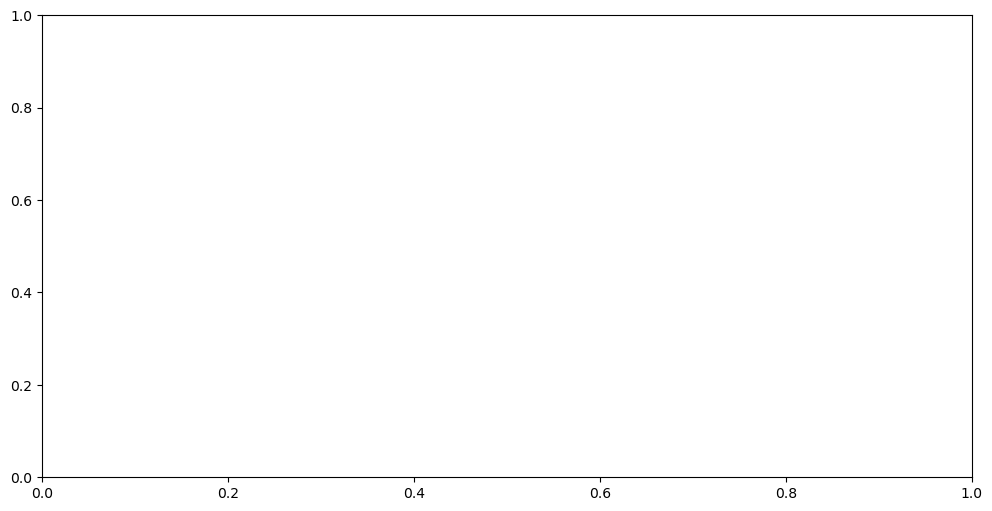

In [150]:
analyze_dataset("MMLU","ablations")

In [ ]:
analyze_dataset("CSQA","ablations")

Loading (29223, 18) results from results/csqa_quoted/_n_netscratch_dwork_lab_Lab_katrina_finetuning_sbp_meta-llama_Llama-2-7b-hf_mmlu_quoted_qa_20250109-090124-False_final_weights-50


# Cached logs

In [144]:
analyze_perplexity(model_pairs,"llama_family")

No loss file found at /n/netscratch/dwork_lab/Lab/katrina/finetuning_sbp/meta-llama/Llama-2-7b-hf/mmlu_quoted_qa_wiki/20250109-092335-False/loss.jsonl


In [145]:
analyze_dataset("MMLU","llama_family")

Loading (30888, 18) results from /n/netscratch/dwork_lab/Lab/katrina/set-based-prompting-finetuning/results/mmlu_quoted_permutations/meta-llama_Llama-2-7b-chat-hf-50
Loading (18414, 18) results from /n/netscratch/dwork_lab/Lab/katrina/set-based-prompting-finetuning/results/mmlu_quoted/meta-llama_Llama-2-13b-hf-50
Loading (13224, 18) results from /n/netscratch/dwork_lab/Lab/katrina/set-based-prompting-finetuning/results/mmlu_quoted/_n_netscratch_dwork_lab_Lab_katrina_finetuning_sbp_meta-llama_Llama-2-13b-hf_mmlu_quoted_qa_wiki_20250110-002528-False_final_weights-50
Loading (30888, 18) results from /n/netscratch/dwork_lab/Lab/katrina/set-based-prompting-finetuning/results/mmlu_quoted_permutations/meta-llama_Llama-2-13b-hf-50
Loading (8796, 18) results from /n/netscratch/dwork_lab/Lab/katrina/set-based-prompting-finetuning/results/mmlu_quoted/meta-llama_Llama-2-13b-chat-hf-50
Loading (13224, 18) results from /n/netscratch/dwork_lab/Lab/katrina/set-based-prompting-finetuning/results/mmlu_q

In [146]:
analyze_dataset("CSQA","llama_family")

Loading (29223, 18) results from /n/netscratch/dwork_lab/Lab/katrina/set-based-prompting-finetuning/results/csqa_quoted/meta-llama_Llama-2-7b-chat-hf-50
Loading (29223, 18) results from /n/netscratch/dwork_lab/Lab/katrina/set-based-prompting-finetuning/results/csqa_quoted/_n_netscratch_dwork_lab_Lab_katrina_finetuning_sbp_meta-llama_Llama-2-7b-chat-hf_mmlu_quoted_qa_wiki_20250110-001813-False_final_weights-50
Loading (67500, 18) results from /n/netscratch/dwork_lab/Lab/katrina/set-based-prompting-finetuning/results/csqa_quoted_permutations/meta-llama_Llama-2-7b-chat-hf-50
Loading (2118, 18) results from /n/netscratch/dwork_lab/Lab/katrina/set-based-prompting-finetuning/results/csqa_quoted/meta-llama_Llama-2-13b-hf-50
Loading (29223, 18) results from /n/netscratch/dwork_lab/Lab/katrina/set-based-prompting-finetuning/results/csqa_quoted/_n_netscratch_dwork_lab_Lab_katrina_finetuning_sbp_meta-llama_Llama-2-13b-hf_mmlu_quoted_qa_wiki_20250110-002528-False_final_weights-50
Loading (67500, 1

AttributeError: 'NoneType' object has no attribute 'assign'

In [141]:
analyze_dataset("CSQA","llama_family")




Llama-2-7b : QA+wiki 9741 post datapoints
Llama-2-7b : QA+wiki : train_csqa 6000 post datapoints
Llama-2-7b : QA+wiki (1 epoch) 9741 post datapoints
Barplot CSQA Accuracy:
Type                               Normal  Pre-OID  Post-OID
Model                                                       
Llama-2-7b : QA+wiki                0.256    0.302     0.486
Llama-2-7b : QA+wiki (1 epoch)      0.256    0.302     0.480
Llama-2-7b : QA+wiki : train_csqa   0.258    0.305     0.595
After filtering to only create permutation boxplot from common rows: df_post.shape=(3000, 18)
Llama-2-7b : QA+wiki                 1000
Llama-2-7b : QA+wiki : train_csqa    1000
Llama-2-7b : QA+wiki (1 epoch)       1000
Name: model, dtype: int64
Boxplot CSQA Accuracy:
                                   Pre-OID  Post-OID
Llama-2-7b : QA+wiki                 0.321     0.507
Llama-2-7b : QA+wiki (1 epoch)       0.321     0.501
Llama-2-7b : QA+wiki : train_csqa    0.321     0.601
